In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Para gráficos mais bonitos

# Configurações para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)

print("Setup inicial e importações concluídos.")

Setup inicial e importações concluídos.


In [2]:
# --- Funções do Deep Learning ---
def load_and_preprocess_data():
    digits = load_digits()
    X = digits.data / 16.0
    y = digits.target
    x_treino, x_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)
    return x_treino, x_teste, y_treino, y_teste, digits.images

def build_model_for_ag_fitness(input_shape, hidden_layer_1_weights=None, hidden_layer_1_biases=None):
    """
    Constrói o modelo Keras.
    Se hidden_layer_1_weights/biases forem fornecidos, define-os e congela a camada.
    Caso contrário, a camada será treinável.
    """
    model = keras.Sequential([
        keras.layers.InputLayer(shape=input_shape),
        keras.layers.Dense(128, activation='relu', name='ag_hidden_layer'), # Nomeamos para fácil acesso
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])

    if hidden_layer_1_weights is not None and hidden_layer_1_biases is not None:
        # Define os pesos da camada que o AG está otimizando
        model.get_layer('ag_hidden_layer').set_weights([hidden_layer_1_weights, hidden_layer_1_biases])
        # Congela esta camada para que o otimizador Keras não a altere
        model.get_layer('ag_hidden_layer').trainable = False

    # Compila o modelo. O otimizador só afetará as camadas treináveis.
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='rmsprop',
        metrics=['sparse_categorical_accuracy']
    )
    return model

# --- Funções Auxiliares para Manipulação de Pesos ---
def flatten_weights(weights_list):
    """Achata uma lista de arrays de pesos (W, b) em um único vetor."""
    flattened = []
    for arr in weights_list:
        flattened.extend(arr.flatten())
    return np.array(flattened)

def unflatten_weights(flat_weights, layer_shapes):
    """
    Remodela um vetor achatado de pesos de volta para o formato original (W, b).
    `layer_shapes` deve ser uma lista de tuplas (shape_W, shape_b) para a camada.
    """
    reshaped_weights = []
    current_index = 0
    for w_shape, b_shape in layer_shapes:
        # Pesos (W)
        size_w = np.prod(w_shape)
        w = flat_weights[current_index : current_index + size_w].reshape(w_shape)
        reshaped_weights.append(w)
        current_index += size_w

        # Vieses (b)
        size_b = np.prod(b_shape)
        b = flat_weights[current_index : current_index + size_b].reshape(b_shape)
        reshaped_weights.append(b)
        current_index += size_b
    return reshaped_weights

print("Funções base e auxiliares definidas.")

Funções base e auxiliares definidas.


In [3]:
# --- Carregar e Preparar Dados ---
x_treino, x_teste, y_treino, y_teste, _ = load_and_preprocess_data()

# Para a função de aptidão, usaremos uma parte do treino para validação interna do AG
# E o conjunto de teste final para a avaliação do modelo com os melhores pesos do AG.
x_ag_val, x_ag_train, y_ag_val, y_ag_train = train_test_split(x_treino, y_treino, test_size=0.7, random_state=42)

# Determinar as formas dos pesos da camada oculta que o AG vai otimizar
# (Entrada 64 -> Oculta 128)
# A camada 'ag_hidden_layer' tem índice 1 no modelo Sequential
temp_model = build_model_for_ag_fitness(input_shape=[64])
hidden_layer_1_weights_keras_format = temp_model.get_layer('ag_hidden_layer').get_weights()
hidden_layer_shapes = [(hidden_layer_1_weights_keras_format[0].shape, hidden_layer_1_weights_keras_format[1].shape)]
individual_size = len(flatten_weights(hidden_layer_1_weights_keras_format))

print(f"Número de neurônios de entrada: {x_treino.shape[1]}")
print(f"Tamanho de um indivíduo AG (vetor de pesos achatado): {individual_size}")

print("\nResumo da arquitetura da MLP para inspeção:")
temp_model.summary()

# --- Parâmetros do Algoritmo Genético ---
POPULATION_SIZE = 50       # Número de indivíduos na população
NUM_GENERATIONS = 30       # Número de gerações a serem executadas
MUTATION_RATE = 0.05       # Probabilidade de um peso sofrer mutação
CROSSOVER_PROBABILITY = 0.8 # Probabilidade de dois pais cruzarem
NUM_PARENTS_TO_SELECT = POPULATION_SIZE
ELITE_COUNT = 2            # Quantos dos melhores indivíduos passam diretamente para a próxima geração (elitismo)

print("\nParâmetros do Algoritmo Genético definidos:")
params_df = pd.DataFrame({
    'Parâmetro': ['POPULATION_SIZE', 'NUM_GENERATIONS', 'MUTATION_RATE', 'CROSSOVER_PROBABILITY', 'ELITE_COUNT', 'Individual Size'],
    'Valor': [POPULATION_SIZE, NUM_GENERATIONS, MUTATION_RATE, CROSSOVER_PROBABILITY, ELITE_COUNT, individual_size]
})
print(params_df.to_string(index=False))

Número de neurônios de entrada: 64
Tamanho de um indivíduo AG (vetor de pesos achatado): 8320

Resumo da arquitetura da MLP para inspeção:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ag_hidden_layer (Dense)         │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,226 (67.29 KB)

 Trainable params: 17,226 (67.29 KB)

 Non-trainable params: 0 (0.00 B)


Parâmetros do Algoritmo Genético definidos:
            Parâmetro   Valor
      POPULATION_SIZE   50.00
      NUM_GENERATIONS   30.00
        MUTATION_RATE    0.05
CROSSOVER_PROBABILITY    0.80
          ELITE_COUNT    2.00
      Individual Size 8320.00


In [4]:
# --- Funções do Algoritmo Genético ---

### **Passo 1: Gerar População Inicial**
def generate_initial_population(pop_size, individual_size):
    population = [np.random.uniform(low=-1.0, high=1.0, size=individual_size) for _ in range(pop_size)]
    return population

### **Passo 2: Avaliar Aptidão (Fitness)**
def evaluate_fitness(individual, x_val, y_val, model_input_shape, hidden_layer_shapes_info):
    weights_w_b = unflatten_weights(individual, hidden_layer_shapes_info)
    hidden_weights = weights_w_b[0]
    hidden_biases = weights_w_b[1]

    model = build_model_for_ag_fitness(model_input_shape,
                                       hidden_layer_1_weights=hidden_weights,
                                       hidden_layer_1_biases=hidden_biases)

    # Pequeno treino para as outras camadas se adaptarem
    model.fit(x_ag_train, y_ag_train, epochs=5, verbose=0)

    _, accuracy = model.evaluate(x_val, y_val, verbose=0)
    return accuracy

### **Passo 3: Verificar Condição de Término** (Função de monitoramento)
def check_termination_condition(generation, max_generations, best_fitness_current_gen):
    return generation >= max_generations

### **Passo 4: Seleção**
def select_parents(population, fitness_scores, num_parents_to_select, elite_count=1):
    sorted_indices = np.argsort(fitness_scores)[::-1]
    sorted_population = [population[i] for i in sorted_indices]

    parents = sorted_population[:elite_count]

    for _ in range(num_parents_to_select - elite_count):
        # Seleção por Torneio: seleciona um pequeno grupo e escolhe o melhor
        candidate_indices = np.random.choice(len(population), size=min(5, len(population)), replace=False)
        tournament_candidates = [population[i] for i in candidate_indices]
        tournament_fitness = [fitness_scores[i] for i in candidate_indices]
        best_in_tournament_idx = np.argmax(tournament_fitness)
        parents.append(tournament_candidates[best_in_tournament_idx])

    return parents

### **Passo 5: Cruzamento (Crossover)**
def crossover(parent1, parent2):
    crossover_point = np.random.randint(1, len(parent1))
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

### **Passo 6: Mutação**
def mutate(individual, mutation_rate, mutation_strength=0.1):
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            individual[i] += np.random.uniform(-mutation_strength, mutation_strength)
            individual[i] = np.clip(individual[i], -1.0, 1.0) # Garante limites de pesos
    return individual

### **Passo 7: Substituir População Antiga**
def replace_population(old_population, parents, new_children, pop_size, elite_count=1):
    new_population_local = parents[:elite_count]

    current_children_idx = 0
    while len(new_population_local) < pop_size and current_children_idx < len(new_children):
        new_population_local.append(new_children[current_children_idx])
        current_children_idx += 1

    while len(new_population_local) < pop_size: # Preenche se ainda faltar (raro)
        new_population_local.append(np.random.uniform(low=-1.0, high=1.0, size=individual_size))

    return new_population_local

print("Funções do Algoritmo Genético definidas.")

Funções do Algoritmo Genético definidas.


In [6]:
print("\n--- Iniciando Otimização com Algoritmo Genético ---")
print(f"Parâmetros: População={POPULATION_SIZE}, Gerações={NUM_GENERATIONS}, Mutação={MUTATION_RATE}, Crossover={CROSSOVER_PROBABILITY}")

# Variáveis para capturar o progresso
history_best_fitness = []
history_avg_fitness = []
best_fitness_overall = -np.inf
best_individual_overall = None
all_individuals_data = [] # Para análise de diversidade

# 1. Gerar População Inicial
population = generate_initial_population(POPULATION_SIZE, individual_size)

print(f"\nPopulação inicial gerada. Total de indivíduos: {len(population)}")

# Loop para os passos 2 a 7 (Gerações)
for generation in range(NUM_GENERATIONS):
    print(f"\n--- Geração {generation + 1}/{NUM_GENERATIONS} ---")

    # 2. Avaliar Aptidão
    print("  Avaliando Aptidão da População...")
    # CORREÇÃO: x_treino.shape[1] envolto em uma tupla para o input_shape
    fitness_scores = [evaluate_fitness(ind, x_ag_val, y_ag_val, (x_treino.shape[1],), hidden_layer_shapes) for ind in population]

    current_best_fitness = np.max(fitness_scores)
    current_avg_fitness = np.mean(fitness_scores)
    current_best_individual_idx = np.argmax(fitness_scores)
    current_best_individual = population[current_best_individual_idx]

    history_best_fitness.append(current_best_fitness)
    history_avg_fitness.append(current_avg_fitness)

    # Captura dados de indivíduos para análise de diversidade (ex: para a primeira e última geração)
    if generation == 0 or generation == NUM_GENERATIONS - 1:
        for idx, ind in enumerate(population):
            all_individuals_data.append({
                'Generation': generation + 1,
                'Individual_ID': idx,
                'Fitness': fitness_scores[idx],
                'Weights_Mean': np.mean(ind),
                'Weights_Std': np.std(ind)
            })

    if current_best_fitness > best_fitness_overall:
        best_fitness_overall = current_best_fitness
        best_individual_overall = current_best_individual

    print(f"  Melhor Aptidão na Geração: {current_best_fitness:.4f}")
    print(f"  Média de Aptidão na Geração: {current_avg_fitness:.4f}")

    # 3. Verificar Condição de Término (monitoramento, o loop já é a condição principal)
    # check_termination_condition(generation, NUM_GENERATIONS, current_best_fitness) # Já monitorado pelos prints

    # 4. Seleção
    # print("  Realizando Seleção dos Pais...")
    parents = select_parents(population, fitness_scores, NUM_PARENTS_TO_SELECT, ELITE_COUNT)

    new_children = []
    num_children_needed = POPULATION_SIZE - ELITE_COUNT

    # 5. Cruzamento
    # print("  Realizando Cruzamento...")
    for i in range(0, NUM_PARENTS_TO_SELECT, 2):
        if i + 1 < NUM_PARENTS_TO_SELECT and np.random.rand() < CROSSOVER_PROBABILITY:
            child1, child2 = crossover(parents[i], parents[i+1])
            new_children.append(child1)
            new_children.append(child2)
        else:
            new_children.append(parents[i])
            if i + 1 < NUM_PARENTS_TO_SELECT:
                new_children.append(parents[i+1])

    new_children = new_children[:num_children_needed] # Ajusta para o número exato necessário

    # 6. Mutação
    # print("  Aplicando Mutação aos Filhos...")
    new_children = [mutate(child, MUTATION_RATE) for child in new_children]

    # 7. Substituir População Antiga
    # print("  Substituindo População...")
    population = replace_population(population, parents, new_children, POPULATION_SIZE, ELITE_COUNT)

print("\n--- Otimização com AG Concluída! ---")
print(f"Melhor Aptidão Geral Encontrada: {best_fitness_overall:.4f}")


--- Iniciando Otimização com Algoritmo Genético ---
Parâmetros: População=50, Gerações=30, Mutação=0.05, Crossover=0.8

População inicial gerada. Total de indivíduos: 50

--- Geração 1/30 ---
  Avaliando Aptidão da População...
  Melhor Aptidão na Geração: 0.9374
  Média de Aptidão na Geração: 0.9189

--- Geração 2/30 ---
  Avaliando Aptidão da População...
  Melhor Aptidão na Geração: 0.9443
  Média de Aptidão na Geração: 0.9210

--- Geração 3/30 ---
  Avaliando Aptidão da População...
  Melhor Aptidão na Geração: 0.9490
  Média de Aptidão na Geração: 0.9240

--- Geração 4/30 ---
  Avaliando Aptidão da População...
  Melhor Aptidão na Geração: 0.9513
  Média de Aptidão na Geração: 0.9252

--- Geração 5/30 ---
  Avaliando Aptidão da População...
  Melhor Aptidão na Geração: 0.9490
  Média de Aptidão na Geração: 0.9264

--- Geração 6/30 ---
  Avaliando Aptidão da População...
  Melhor Aptidão na Geração: 0.9559
  Média de Aptidão na Geração: 0.9302

--- Geração 7/30 ---
  Avaliando Apt

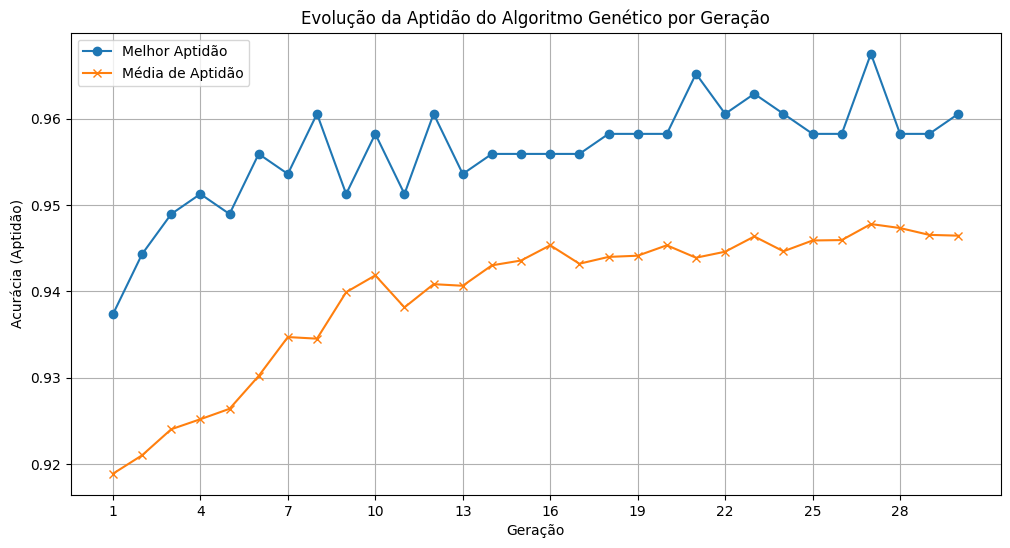

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, NUM_GENERATIONS + 1), history_best_fitness, label='Melhor Aptidão', marker='o')
plt.plot(range(1, NUM_GENERATIONS + 1), history_avg_fitness, label='Média de Aptidão', marker='x')
plt.title('Evolução da Aptidão do Algoritmo Genético por Geração')
plt.xlabel('Geração')
plt.ylabel('Acurácia (Aptidão)')
plt.grid(True)
plt.legend()
plt.xticks(range(1, NUM_GENERATIONS + 1, max(1, NUM_GENERATIONS // 10))) # Ajusta ticks para melhor visualização
plt.show()

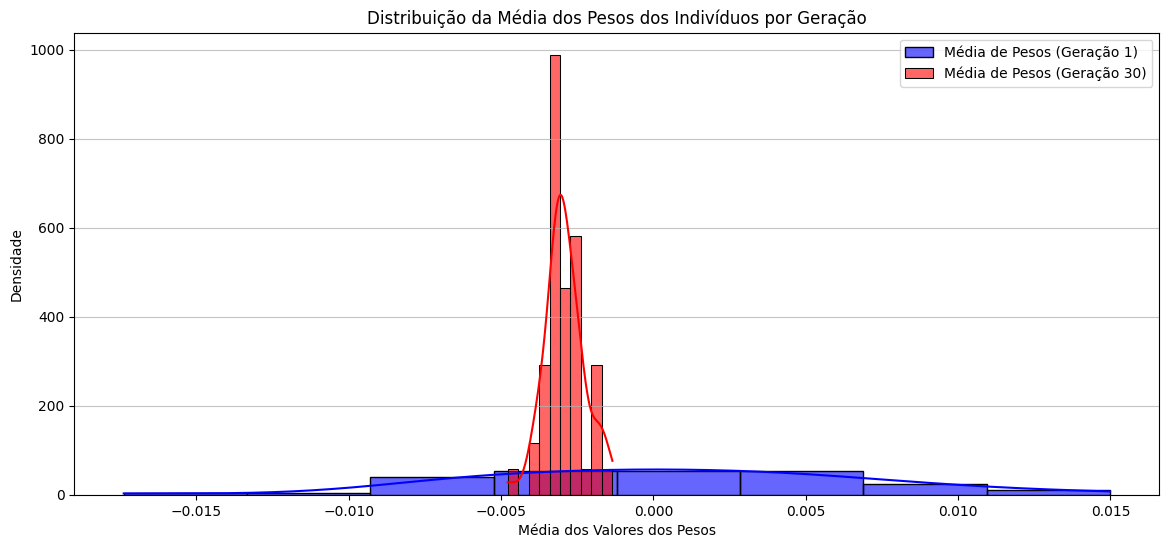

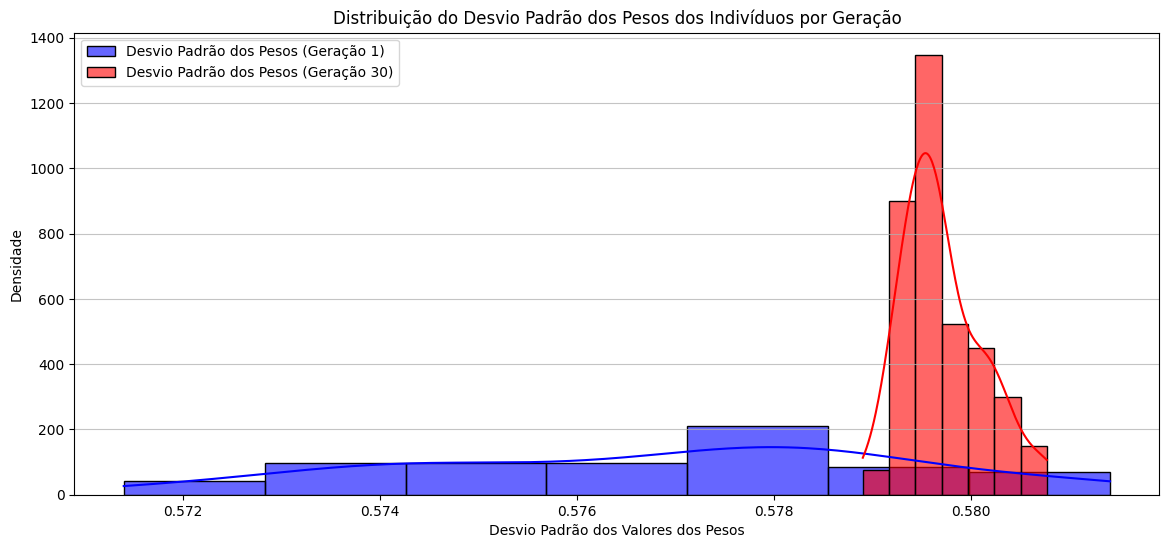

In [8]:
individuals_df = pd.DataFrame(all_individuals_data)

plt.figure(figsize=(14, 6))
sns.histplot(individuals_df[individuals_df['Generation'] == 1]['Weights_Mean'],
             color='blue', label='Média de Pesos (Geração 1)', kde=True, stat='density', alpha=0.6)
sns.histplot(individuals_df[individuals_df['Generation'] == NUM_GENERATIONS]['Weights_Mean'],
             color='red', label=f'Média de Pesos (Geração {NUM_GENERATIONS})', kde=True, stat='density', alpha=0.6)
plt.title('Distribuição da Média dos Pesos dos Indivíduos por Geração')
plt.xlabel('Média dos Valores dos Pesos')
plt.ylabel('Densidade')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

plt.figure(figsize=(14, 6))
sns.histplot(individuals_df[individuals_df['Generation'] == 1]['Weights_Std'],
             color='blue', label='Desvio Padrão dos Pesos (Geração 1)', kde=True, stat='density', alpha=0.6)
sns.histplot(individuals_df[individuals_df['Generation'] == NUM_GENERATIONS]['Weights_Std'],
             color='red', label=f'Desvio Padrão dos Pesos (Geração {NUM_GENERATIONS})', kde=True, stat='density', alpha=0.6)
plt.title('Distribuição do Desvio Padrão dos Pesos dos Indivíduos por Geração')
plt.xlabel('Desvio Padrão dos Valores dos Pesos')
plt.ylabel('Densidade')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

In [9]:
print("\nAplicando os melhores pesos encontrados pelo AG ao modelo final...")

# Remodelar o melhor indivíduo para o formato Keras
best_weights_w_b = unflatten_weights(best_individual_overall, hidden_layer_shapes)
final_hidden_weights = best_weights_w_b[0]
final_hidden_biases = best_weights_w_b[1]

# Constrói o modelo final com os pesos AG e treina as outras camadas
final_model_ag_optimized = build_model_for_ag_fitness(
    input_shape=[64],
    hidden_layer_1_weights=final_hidden_weights,
    hidden_layer_1_biases=final_hidden_biases
)

print("\nTreinando as outras camadas do modelo final para se adaptarem aos pesos AG...")
# Treine as camadas "não AG" no conjunto de treinamento completo
final_model_ag_optimized.fit(x_treino, y_treino, epochs=50, verbose=1)

print("\nAvaliando o Modelo Final Otimizado com AG no Conjunto de Teste Completo:")
loss_ag_final, accuracy_ag_final = final_model_ag_optimized.evaluate(x_teste, y_teste, verbose=0)
print(f"Perda no Teste (Modelo AG-Otimizado): {loss_ag_final:.4f}")
print(f"Acurácia no Teste (Modelo AG-Otimizado): {accuracy_ag_final:.4f}")

# Exemplo de relatório final em tabela
final_results_df = pd.DataFrame({
    'Métrica': ['Melhor Aptidão do AG', 'Acurácia Final no Teste', 'Perda Final no Teste'],
    'Valor': [f'{best_fitness_overall:.4f}', f'{accuracy_ag_final:.4f}', f'{loss_ag_final:.4f}']
})
print("\n--- Resumo dos Resultados Finais ---")
print(final_results_df.to_string(index=False))


Aplicando os melhores pesos encontrados pelo AG ao modelo final...

Treinando as outras camadas do modelo final para se adaptarem aos pesos AG...
Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2772 - sparse_categorical_accuracy: 0.3588
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6535 - sparse_categorical_accuracy: 0.8835
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3303 - sparse_categorical_accuracy: 0.9343
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2204 - sparse_categorical_accuracy: 0.9548
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1667 - sparse_categorical_accuracy: 0.9595
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1332 - sparse_categorical_accuracy: 0.9663
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1092 - sparse_categorical_accuracy: 0.9716
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0907 - sparse_categorical_accuracy: 0.9755
Epoch 9/50
45/45 ━━━━━━━━━━━━

# =============================
# 7. Conclusões e Próximos Passos
# =============================

 Este relatório apresenta um fluxo completo de otimização híbrida combinando Algoritmos Genéticos (AG) e Deep Learning.
As visualizações ajudam a compreender a evolução da população e o impacto da otimização genética nos pesos da rede neural.

🔍 Destaques:
- A curva de aptidão (melhor e média) por geração evidencia que o AG é capaz de encontrar soluções progressivamente melhores.
 - A análise de distribuição dos pesos mostra como o AG direciona a configuração da camada otimizada ao longo das gerações.
- A acurácia final no conjunto de teste valida a eficácia do modelo híbrido.

🚀 Próximos Passos Sugeridos:
1. Comparação com modelo clássico: treinar uma MLP puramente com RMSprop (sem AG) para comparar os resultados.
2. Ajuste de hiperparâmetros do AG: testar diferentes tamanhos de população, taxas de mutação, probabilidades de cruzamento e número de gerações.
3. Otimização de múltiplas camadas: aplicar AG na configuração de mais de uma camada ou até na arquitetura completa da rede.
4. Visualização dos indivíduos: explorar como os "melhores" pesos influenciam a representação interna dos dados.